In [1]:
!pip install mediapipe

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import mediapipe as mp
import time

mp_drawing  = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [ ]:
import numpy as np

POSE_NOSE = 0
POSE_LEFT_EYE_OUTER  = 3
POSE_RIGHT_EYE_OUTER = 6
POSE_MOUTH_LEFT  = 9
POSE_MOUTH_RIGHT = 10

def _safe_xy(lmk):
    return (getattr(lmk, 'x', 0.0), getattr(lmk, 'y', 0.0))

def extract_keypoints(results):
    if results.pose_landmarks:
        pose_lm = results.pose_landmarks.landmark
        pose = np.array([[l.x, l.y, l.z, l.visibility] for l in pose_lm], dtype=np.float32).flatten()
        le_x, le_y = _safe_xy(pose_lm[POSE_LEFT_EYE_OUTER])
        re_x, re_y = _safe_xy(pose_lm[POSE_RIGHT_EYE_OUTER])
        nose_x, nose_y = _safe_xy(pose_lm[POSE_NOSE])
        fc_x = (le_x + re_x)/2.0 if (le_x or re_x) else nose_x
        fc_y = (le_y + re_y)/2.0 if (le_y or re_y) else nose_y
        face_scale = np.hypot(le_x - re_x, le_y - re_y)
        if face_scale < 1e-6: face_scale = 1e-3
    else:
        pose = np.zeros(33*4, dtype=np.float32)
        fc_x = fc_y = 0.0
        face_scale = 1e-3

    if results.left_hand_landmarks:
        lh_raw = np.array([[l.x, l.y, l.z] for l in results.left_hand_landmarks.landmark], dtype=np.float32)
    else:
        lh_raw = np.zeros((21,3), dtype=np.float32)

    if results.right_hand_landmarks:
        rh_raw = np.array([[l.x, l.y, l.z] for l in results.right_hand_landmarks.landmark], dtype=np.float32)
    else:
        rh_raw = np.zeros((21,3), dtype=np.float32)

    def norm_xy(arr):
        arr = arr.copy()
        arr[:,0] = (arr[:,0] - fc_x) / face_scale  
        arr[:,1] = (arr[:,1] - fc_y) / face_scale 
        return arr

    if results.pose_landmarks:
        pose_xyz = np.array([[l.x, l.y, l.z] for l in results.pose_landmarks.landmark], dtype=np.float32)
        pose_xyz = norm_xy(pose_xyz)
        pose_vis = np.array([[l.visibility] for l in results.pose_landmarks.landmark], dtype=np.float32)
        pose = np.concatenate([pose_xyz, pose_vis], axis=1).flatten()
    lh = norm_xy(lh_raw).flatten()
    rh = norm_xy(rh_raw).flatten()

    return np.concatenate([pose, lh, rh]).astype(np.float32)

In [7]:
import os, numpy as np
from pathlib import Path

DATASET_PATH = r"D:\Mhd\Dataset 3 signers 30 words"

actions = np.array(sorted([d.name for d in Path(DATASET_PATH).iterdir() if d.is_dir()]))
print("Found actions:", actions.tolist())

sequence_length_target = 60
feature_dim = 258

IMG_EXTS = {'.jpg', '.jpeg', '.png'}

no_sequences = 30 

Found actions: ['0088', '0095', '0115', '0125', '0131', '0157', '0159', '0160', '0161', '0162', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0178', '0184', '0187', '0195', '0196', '0197', '0255', '0256', '0260', '0287', '0288', '0289', '0293']


In [16]:
pip install tensorflow  


  Using cached charset_normalizer-3.4.3-cp310-cp310-win_amd64.whl.metadata (37 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
   ---------------------------------------- 1.3/331.7 MB 5.6 MB/s eta 0:00:59
   ---------------------------------------- 2.6/331.7 MB 6.0 MB/s eta 0:00:55
   ---------------------------------------- 3.9/331.7 MB 6.0 MB/s eta 0:00:55
    --------------------------------------- 5.8/331.7 MB 6.8 MB/s eta 0:00:49
    --------------------------------------- 6.8/331.7 MB 6.8 MB/s eta 0:00:49
    --------------------------------------- 7.9/331.7 MB 5.9 MB/s eta 0:00:55
   - -------------------------------------- 8.7/331.7 MB 5.7 MB/s eta 0:00:58
   - ---------------------------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 6.32.0 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
#pre-processing the data using mediapipe, to get the data ready for training
#the data is in the form of separate frames of a video of type jpeg, and we are here turning each frame into an array of the landmarks
#the landmarks are the points on the face (very minimal points), the body, and the hands


import cv2, mediapipe as mp
import numpy as np
from pathlib import Path

mp_holistic = mp.solutions.holistic

def list_frame_folders(dataset_root: str):
    
    root = Path(dataset_root)
    for action in actions:
        for candidate in (root / action).rglob('*'):
            if candidate.is_dir():
                has_frames = any(p.suffix.lower() in IMG_EXTS for p in candidate.iterdir() if p.is_file())
                if has_frames:
                    yield action, candidate

def sorted_frames_in(seq_dir: Path):
    frames = [p for p in seq_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    frames.sort(key=lambda p: p.name)
    return frames

def sample_indices(n, L):
    
    if n <= 0:
        return []
    if n >= L:
        return list(np.linspace(0, n-1, L).astype(int))
    idx = list(range(n))
    idx += [n-1] * (L - n)
    return idx

X_list, y_list = [], []

with mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    refine_face_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:

    count = 0
    for action, seq_dir in list_frame_folders(DATASET_PATH):
        frame_paths = sorted_frames_in(seq_dir)
        feats_per_frame = []

        for fp in frame_paths:
            img = cv2.imread(str(fp))
            if img is None:
                continue
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)

            feats = extract_keypoints(results)
            feats_per_frame.append(feats)

        n = len(feats_per_frame)
        if n == 0:
            seq = np.zeros((sequence_length_target, feature_dim), dtype=np.float32)
        else:
            idx = sample_indices(n, sequence_length_target)
            seq = np.stack([feats_per_frame[i] for i in idx], axis=0).astype(np.float32)

        X_list.append(seq)
        y_list.append(int(np.where(actions == action)[0][0]))
        count += 1
        if count % 50 == 0:
            print(f"Processed {count} sequences...")

X = np.stack(X_list, axis=0)
y = np.array(y_list, dtype=int)
y = to_categorical(y, num_classes=len(actions))
print("X:", X.shape, " y:", y.shape, " classes:", len(actions))

NameError: name 'DATASET_PATH' is not defined

In [ ]:
import numpy as np

def augment_sequence(seq):
    
    seq = seq.copy()

    jitter = np.random.normal(0, 0.01, size=seq.shape)
    seq += jitter

    scale = np.random.uniform(0.9, 1.1)
    seq *= scale

    if np.random.rand() < 0.5:
        seq[:, 0::3] = -seq[:, 0::3]

    return seq.astype('float32')

augmented_X, augmented_y = [], []
for i in range(len(X)):
    augmented_X.append(augment_sequence(X[i]))
    augmented_y.append(y[i])

augmented_X = np.stack(augmented_X)
augmented_y = np.stack(augmented_y)

X_aug = np.concatenate([X, augmented_X], axis=0)
y_aug = np.concatenate([y, augmented_y], axis=0)

print("Original:", X.shape, y.shape)
print("Augmented:", X_aug.shape, y_aug.shape)

Original: (3762, 60, 258) (3762, 30)
Augmented: (7524, 60, 258) (7524, 30)


In [ ]:
#to save the processed data to the disk, so that we don't have to always keep processing the data
import numpy as np

np.save("X_train_feats.npy", X)
np.save("y_train_feats.npy", y)
np.save("actions.npy", actions)
print("Saved X, y, and actions to disk.")

Saved X, y, and actions to disk.


In [ ]:
#loading the saved processed data
import numpy as np 

X = np.load("X_train_feats.npy").astype('float32')
y = np.load("y_train_feats.npy").astype('float32')
actions = np.load("actions.npy")

In [ ]:
#filtering the sequences that might be mostly zeroes
def is_mostly_zero(seq, thresh_frames=24):
    return sum((f==0).all() for f in seq) >= thresh_frames

keep_X, keep_y = [], []
for i, seq in enumerate(X):
    if not is_mostly_zero(seq):
        keep_X.append(seq); keep_y.append(y[i])
X = np.array(keep_X); y = np.array(keep_y)
print("After filtering:", X.shape, y.shape)

After filtering: (3762, 60, 258) (3762,)


In [20]:
import shutil, os
for action in actions:
    for seq in os.listdir(os.path.join(DATA_PATH, action)):
        seq_path = os.path.join(DATA_PATH, action, seq)
        if not os.path.isdir(seq_path): 
            continue
        if len(os.listdir(seq_path)) == 0:
            shutil.rmtree(seq_path)

In [ ]:
#just checking to make sure the shapes are correct
print("y shape:", y.shape)
print("Example y row:", y[0])
print("Row sum:", y[0].sum())


y shape: (3762, 30)
Example y row: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Row sum: 1.0


Building the model next:


In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
#Now building the LSTM model neural network
actions = np.array(actions)
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Bidirectional

num_classes = actions.shape[0]
inp = tf.keras.Input(shape=(60,258))
x = tf.keras.layers.LayerNormalization()(inp)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.35, recurrent_dropout=0.2))(x)
x = tf.keras.layers.LayerNormalization()(x)


x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inp, out)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss, metrics=['categorical_accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X, y,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - categorical_accuracy: 0.1316 - loss: 3.1400 - val_categorical_accuracy: 0.3880 - val_loss: 2.3050
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - categorical_accuracy: 0.2762 - loss: 2.4785 - val_categorical_accuracy: 0.5146 - val_loss: 1.7782
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - categorical_accuracy: 0.3963 - loss: 2.0565 - val_categorical_accuracy: 0.6749 - val_loss: 1.3502
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - categorical_accuracy: 0.5223 - loss: 1.6989 - val_categorical_accuracy: 0.7803 - val_loss: 1.0831
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - categorical_accuracy: 0.6130 - loss: 1.4591 - val_categorical_accuracy: 0.8308 - val_loss: 0.8997
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - categorical_accuracy: 0.6813 - loss: 1.2882 - val_categorical_accuracy: 0.8946 - val_loss: 0.7897
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - categorical_accuracy: 0.732

KeyboardInterrupt: 

In [45]:
print("X:", X_aug.shape, "dtype:", X_aug.dtype)
print("y:", y_aug.shape, y_aug[:20])
print("Unique labels:", np.unique(y_aug))
print("Num classes in actions:", len(actions))
print("Model output:", model.output_shape)

X: (7524, 60, 258) dtype: float32
y: (7524,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Num classes in actions: 29
Model output: (None, 30)


In [46]:
print("X_aug:", X_aug.shape, X_aug.dtype)
print("y_aug shape:", getattr(y_aug, 'shape', None), "dtype:", y_aug.dtype if hasattr(y_aug,'dtype') else type(y_aug))
print("num classes:", len(actions))
print("Model output:", model.output_shape)

X_aug: (7524, 60, 258) float32
y_aug shape: (7524,) dtype: int32
num classes: 29
Model output: (None, 30)


In [26]:
y = y.astype('float32')
X = X.astype('float32')
print(X.dtype, y.dtype)

float32 float32


In [ ]:
#function that tests the model on the testing dataset provided by the dataset itself


import cv2, mediapipe as mp, numpy as np, re
from pathlib import Path
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

TEST_PATH=r"C:\Users\admin\Desktop\TEST Dataset 3 signers 30 words"
sequence_length_target = 60
feature_dim = 258
IMG_EXTS = {'.jpg', '.jpeg', '.png'}

mp_holistic = mp.solutions.holistic

def leaf_dirs_with_frames(base: Path):
    
    for d in base.rglob('*'):
        if d.is_dir():
            files = [p for p in d.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
            if files:
                yield d

def sorted_frames_in(seq_dir: Path):
    frames = [p for p in seq_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    def num_key(p):
        m = re.findall(r'\d+', p.stem)
        return int(m[0]) if m else p.name
    frames.sort(key=num_key)
    return frames

def sample_indices(n, L):
    if n <= 0: return []
    if n >= L: return list(np.linspace(0, n-1, L).astype(int))
    idx = list(range(n)); idx += [n-1] * (L - n)
    return idx

action_to_idx = {a:i for i,a in enumerate(actions.tolist())}

X_list, y_idx = [], []

with mp_holistic.Holistic(
    static_image_mode=False, model_complexity=1, refine_face_landmarks=False,
    min_detection_confidence=0.5, min_tracking_confidence=0.5
) as holistic:

    total_dirs = 0
    for class_dir in Path(TEST_PATH).iterdir():
        if not class_dir.is_dir(): 
            continue
        act_name = class_dir.name
        if act_name not in action_to_idx:
            continue

        for seq_dir in leaf_dirs_with_frames(class_dir):
            total_dirs += 1
            frame_paths = sorted_frames_in(seq_dir)
            feats_per_frame = []
            for fp in frame_paths:
                img = cv2.imread(str(fp))
                if img is None: 
                    continue
                rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); rgb.flags.writeable = False
                results = holistic.process(rgb)
                feats = extract_keypoints(results)
                feats_per_frame.append(feats)

            n = len(feats_per_frame)
            if n == 0:
                seq = np.zeros((sequence_length_target, feature_dim), dtype=np.float32)
            else:
                idx = sample_indices(n, sequence_length_target)
                seq = np.stack([feats_per_frame[i] for i in idx]).astype(np.float32)

            X_list.append(seq)
            y_idx.append(action_to_idx[act_name])

print(f"Found {total_dirs} candidate sequence dirs; built {len(X_list)} sequences.")

if len(X_list) == 0:
    raise RuntimeError("No sequences found.")

X_test = np.stack(X_list).astype('float32')
y_test = to_categorical(np.array(y_idx, dtype=int), num_classes=len(actions)).astype('float32')
print("X_test:", X_test.shape, " y_test:", y_test.shape)

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", acc)

probs = model.predict(X_test, verbose=0)
pred = probs.argmax(axis=1); true = y_test.argmax(axis=1)
for i in range(min(10, len(pred))):
    print(f"True: {actions[true[i]]:<6}  Pred: {actions[pred[i]]:<6}")

c:\Users\admin\anaconda3\envs\action_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Found 720 candidate sequence dirs; built 720 sequences.
X_test: (720, 60, 258)  y_test: (720, 30)
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.9417 - loss: 0.2312
Test accuracy: 0.9416666626930237
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  
True: 0088    Pred: 0088  


In [ ]:
model.save('Model - 93.32% Training Acc - 94.16% Testing Acc.h5')
import numpy as np
np.save('actions.npy', actions)
print("Saved model and actions.")

Saved model and actions.


In [94]:
del model

In [106]:
model.load_weights('action.h5')

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow import keras

model = keras.models.load_model(r'C:\Users\admin\Desktop\FARID CODE\Model - 93.32% Training Acc - 94.16% Testing Acc.h5')

print("Model loaded successfully!")
print("Model summary:")
model.summary()


Model loaded successfully!
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 60, 258)        │           516 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       165,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,356 (688.89 KB)

 Trainable params: 176,354 (688.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 11. Test in Real Time

In [51]:
from scipy import stats

In [18]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res[:len(actions)]):
        prob = float(np.asarray(prob).squeeze())
        color = colors[num % len(colors)]
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), color, -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame



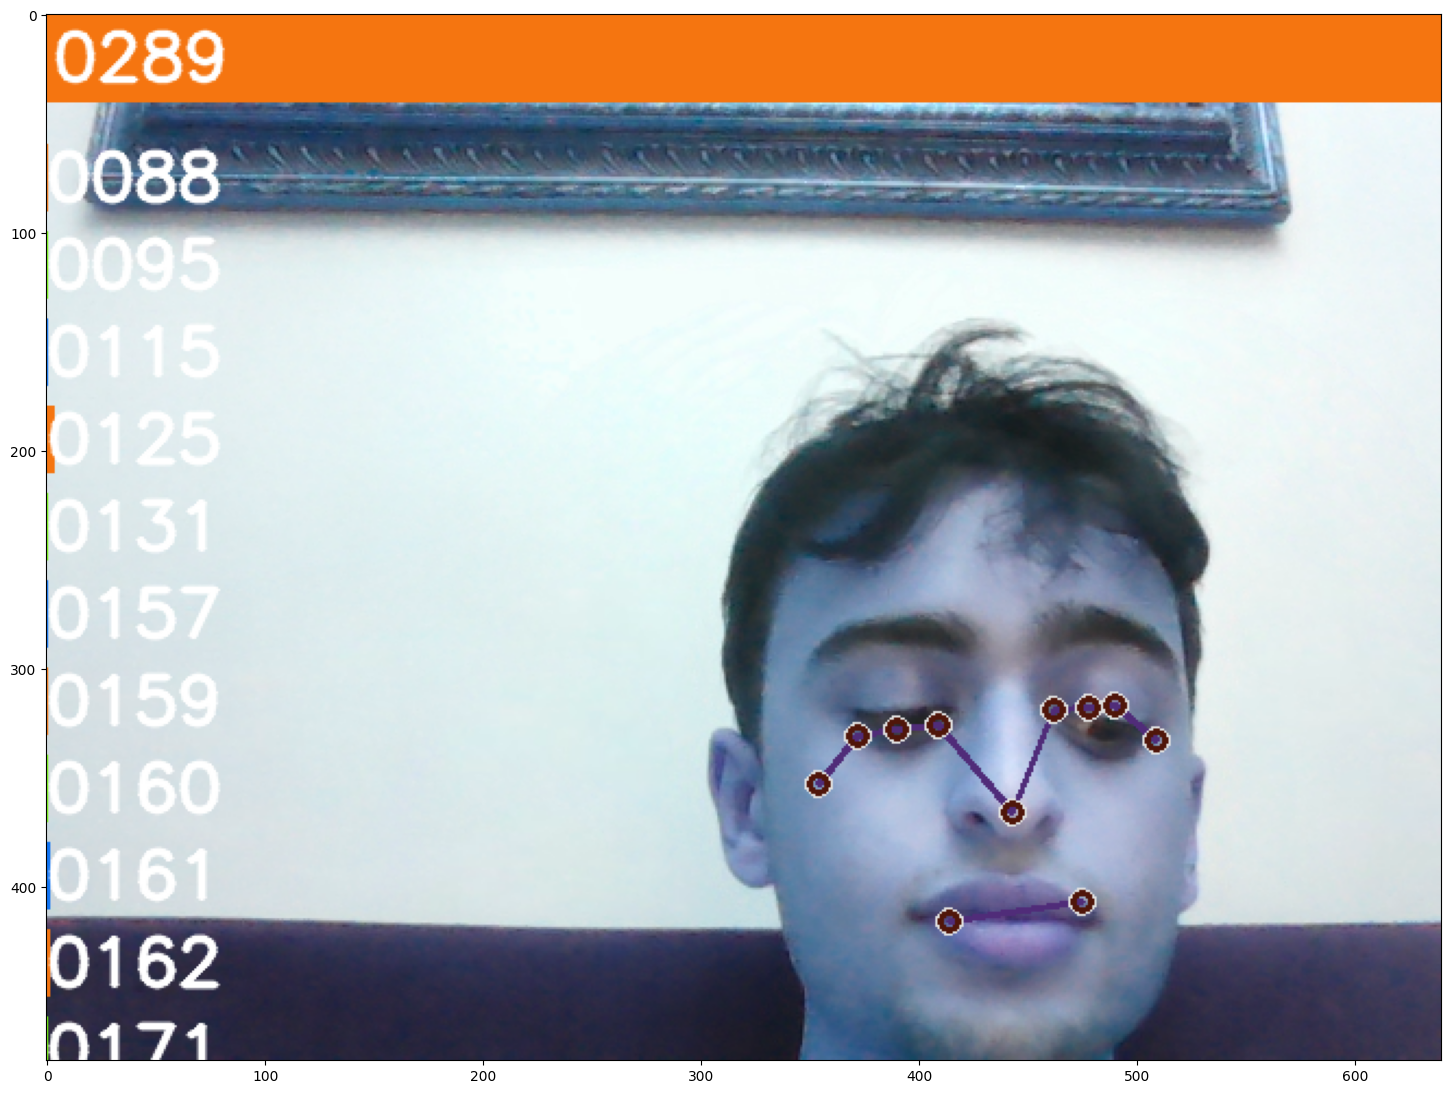

In [24]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [22]:
actions = np.array([
    '0088',
   '0095',
   '0115',
   '0125',
   '0131',
   '0157',
   '0159',
   '0160',
   '0161',
   '0162',
   '0171',
   '0172',
   '0173',
   '0174',
   '0175',
   '0176',
   '0177',
   '0178',
   '0184',
   '0187', 
   '0195',
   '0196',
   '0197',
   '0255',
   '0256', 
   '0260',  
   '0287',
   '0288',
   '0289','0293'
])

no_sequences = 127

sequence_length = 60

In [ ]:
def draw_styled_landmarks(image, results):
    
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )

In [23]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [98]:
import os
print([f for f in os.listdir() if f.endswith(('.npy','.h5'))])

['0.npy']
